In [ ]:
pip install polars

In [ ]:
# import all required libraries
import pandas as pd
import polars as pl
import numpy as np
import re
import time
import psutil
import tracemalloc
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# define track_performance function
def track_performance(start_time, mem_start, process, records):
    elapsed_time = time.time() - start_time
    mem_end = process.memory_info().rss / (1024 * 1024)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    throughput = records / elapsed_time if elapsed_time > 0 else 0

    print(f"\n⏱️ Elapsed Time: {elapsed_time:.2f} sec")
    print(f"📊 Memory Used (Start → End): {mem_start:.2f} MB → {mem_end:.2f} MB")
    print(f"🚀 Peak Memory (tracemalloc): {peak / 1024 / 1024:.2f} MB")
    print(f"📈 Throughput: {throughput:,.2f} records/sec")
    return elapsed_time, mem_end, (peak / 1024 / 102)

In [ ]:
# 1. track performance for normal cleaning process using pandas
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
mem_start = process.memory_info().rss / (1024 * 1024)

# 2. Clean Data Process (Pandas)

df = pd.read_csv("Dataset.csv", encoding="ISO-8859-1")

# a. Drop duplicates
df.drop_duplicates(inplace=True)

df_copy = df.copy()

# b. Replace NaN in specific columns with "unknown"
df_copy["Product Name"].fillna("unknown", inplace=True)
df_copy["Location"].fillna("unknown", inplace=True)
df_copy["Price"].fillna("unknown", inplace=True)

# c.  Fill actual NaN with "0" in critical columns
df_copy["Quantity Sold"].fillna("0", inplace=True)
df_copy["Number of Ratings"].fillna("0", inplace=True)

# d. Clean "Quantity Sold" (e.g., "5K sold" → 5000)
import re
def clean_quantity(q):
    if isinstance(q, str):
        q = q.lower().replace("sold", "").strip()
        if "k" in q:
            return int(float(q.replace("k", "")) * 1000)
        return int(re.findall(r"\d+", q)[0]) if re.findall(r"\d+", q) else 0
    return 0

df_copy["Quantity Sold"] = df_copy["Quantity Sold"].apply(clean_quantity)

# e. Clean "Number of Ratings" (e.g., "(10)" → 10)
def clean_ratings(r):
    if isinstance(r, str):
        match = re.search(r"\d+", r)
        return int(match.group()) if match else 0
    return 0

df_copy["Number of Ratings"] = df_copy["Number of Ratings"].apply(clean_ratings)

# f. Remove non-numerical character in "Price"
df_copy["Price"] = df_copy["Price"].astype(str)

# Clean only rows that are not "unknown"
df_copy.loc[df_copy["Price"] != "unknown", "Price"] = (
    df_copy.loc[df_copy["Price"] != "unknown", "Price"]
    .str.replace(r"[^\d.]", "", regex=True)
)

# g. Convert "Price" to float and leave the word "unknown"
def to_float_or_unknown(val):
    try:
        return float(val)
    except:
        return "unknown"

df_copy["Price"] = df_copy["Price"].apply(to_float_or_unknown)


# h. Convert Quantity Sold & Number of Ratings to int
df_copy["Quantity Sold"] = df_copy["Quantity Sold"].astype(int)
df_copy["Number of Ratings"] = df_copy["Number of Ratings"].astype(int)


# Print sample result
print(df_copy.head())

df_copy.to_csv("pandas_cleaned_Lazada_dataset.csv", index=False)

# 3. record performance
elapsed_pandas, mem_end_pandas, peak_mem_pandas = track_performance(start_time, mem_start, process, df_copy.shape[0])
print(f"📄 Total Records Cleaned: {df_copy.shape[0]}")


<ipython-input-4-9403a97372f6>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy["Product Name"].fillna("unknown", inplace=True)
<ipython-input-4-9403a97372f6>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

                                        Product Name  Price Location  \
0                [NOT FOR SALE] Korean Fashion Cloth    0.1   Penang   
1  ZD [stock] Letter Printed Short-sleeved T-shir...    0.9    China   
2  ZD Summer Yoga Beach Shorts Sports Shorts for ...    1.0    China   
3  HD Summer Yoga Beach Shorts Sports Shorts for ...    1.0    China   
4  4A Shop Running Shorts for Women Spring Summer...    1.0    China   

   Quantity Sold  Number of Ratings  
0              5                  0  
1              0                  0  
2              0                  0  
3              0                  0  
4              0                  0  

⏱️ Elapsed Time: 16.63 sec
📊 Memory Used (Start → End): 247.46 MB → 316.25 MB
🚀 Peak Memory (tracemalloc): 40.92 MB
📈 Throughput: 6,994.26 records/sec
📄 Total Records Cleaned: 116308


In [ ]:
# 1. Start tracking performance
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
mem_start = process.memory_info().rss / (1024 * 1024)

# 2. Load data using pandas with proper encoding, then convert to Polars
print("Loading data with pandas and converting to Polars...")
try:
    pandas_df = pd.read_csv("Dataset.csv", encoding="ISO-8859-1")
    df = pl.from_pandas(pandas_df)
    df_lazy = df.lazy()

    print("\nSchema of the DataFrame:")
    schema = df_lazy.collect_schema()
    for name, dtype in schema.items():
        print(f"- {name}: {dtype}")

    print("\nFirst few rows of raw data:")
    print(df_lazy.fetch(5))

except Exception as e:
    print(f"Error loading data: {e}")
    raise

# 3. Clean Data Process (Polars - Lazy Evaluation)
print("\nPerforming data cleaning operations...")

# a. Drop duplicates
df_lazy = df_lazy.unique(maintain_order=True)

# b. Replace NaN in specific columns with "unknown"
df_lazy = df_lazy.with_columns([
    pl.col("Product Name").fill_null("unknown"),
    pl.col("Location").fill_null("unknown"),
    pl.col("Price").fill_null("unknown")
])

# c. Fill actual NaN with "0" in critical columns
df_lazy = df_lazy.with_columns([
    pl.col("Quantity Sold").fill_null("0"),
    pl.col("Number of Ratings").fill_null("0")
])

# d. Clean "Quantity Sold" (e.g., "5K sold" → 5000)
df_lazy = df_lazy.with_columns([
    pl.when(pl.col("Quantity Sold").cast(pl.Utf8).str.to_lowercase().str.contains("k"))
    .then(
        pl.col("Quantity Sold")
        .cast(pl.Utf8)
        .str.to_lowercase()
        .str.replace_all("sold", "")
        .str.replace_all("k", "")
        .str.extract(r"(\d+\.?\d*)")
        .cast(pl.Float64) * 1000
    )
    .otherwise(
        pl.col("Quantity Sold")
        .cast(pl.Utf8)
        .str.extract(r"(\d+)")
        .cast(pl.Float64)
    )
    .fill_null(0)
    .cast(pl.Int64)
    .alias("Quantity Sold")
])

# e. Clean "Number of Ratings" (e.g., "(10)" → 10)
df_lazy = df_lazy.with_columns([
    pl.col("Number of Ratings")
    .cast(pl.Utf8)
    .str.extract(r"(\d+)")
    .cast(pl.Int64)
    .fill_null(0)
    .alias("Number of Ratings")
])

# f. Process Price column - convert to proper format
df_lazy = df_lazy.with_columns([
    pl.when(pl.col("Price").cast(pl.Utf8) == "unknown")
    .then(pl.lit("unknown"))
    .otherwise(
        pl.col("Price")
        .cast(pl.Utf8)
        .str.replace_all(r"[^\d.]", "")
    )
    .alias("Price")
])

# g. Convert "Price" to float where possible, leave "unknown" as is
df_lazy = df_lazy.with_columns([
    pl.when(pl.col("Price") == "unknown")
    .then(pl.lit(None))
    .otherwise(pl.col("Price").cast(pl.Float64))
    .alias("Price")
])

# 4. Execute all the operations and collect the results
print("\nExecuting all operations and collecting results...")
df_clean = df_lazy.collect()

# Print the results
print("\nSample of cleaned data:")
print(df_clean.head())
print(f"\nShape of cleaned data: {df_clean.shape}")

# 5. Save to CSV
output_path = "polars_cleaned_Lazada_dataset.csv"
df_clean.write_csv(output_path)
print(f"\nSaved cleaned data to {output_path}")

# 6. Track performance
elapsed, mem_end, peak = track_performance(start_time, mem_start, process, df_clean.shape[0])
print(f"📄 Total Records Cleaned: {df_clean.shape[0]}")

Loading data with pandas and converting to Polars...

Schema of the DataFrame:
- Product Name: String
- Price: String
- Location: String
- Quantity Sold: String
- Number of Ratings: String

First few rows of raw data:
shape: (5, 5)
┌─────────────────────────────────┬───────┬──────────┬───────────────┬───────────────────┐
│ Product Name                    ┆ Price ┆ Location ┆ Quantity Sold ┆ Number of Ratings │
│ ---                             ┆ ---   ┆ ---      ┆ ---           ┆ ---               │
│ str                             ┆ str   ┆ str      ┆ str           ┆ str               │
╞═════════════════════════════════╪═══════╪══════════╪═══════════════╪═══════════════════╡
│ [NOT FOR SALE] Korean Fashion … ┆ 0.1   ┆ Penang   ┆ 5 sold        ┆ null              │
│ ZD [stock] Letter Printed Shor… ┆ 0.9   ┆ China    ┆ null          ┆ null              │
│ ZD Summer Yoga Beach Shorts Sp… ┆ 1     ┆ China    ┆ null          ┆ null              │
│ HD Summer Yoga Beach Shorts Sp… ┆ 1   

<ipython-input-7-9c9b2858dfad>:20: DeprecationWarning: `LazyFrame.fetch` is deprecated. `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  print(df_lazy.fetch(5))



Sample of cleaned data:
shape: (5, 5)
┌─────────────────────────────────┬───────┬──────────┬───────────────┬───────────────────┐
│ Product Name                    ┆ Price ┆ Location ┆ Quantity Sold ┆ Number of Ratings │
│ ---                             ┆ ---   ┆ ---      ┆ ---           ┆ ---               │
│ str                             ┆ f64   ┆ str      ┆ i64           ┆ i64               │
╞═════════════════════════════════╪═══════╪══════════╪═══════════════╪═══════════════════╡
│ [NOT FOR SALE] Korean Fashion … ┆ 0.1   ┆ Penang   ┆ 5             ┆ 0                 │
│ ZD [stock] Letter Printed Shor… ┆ 0.9   ┆ China    ┆ 0             ┆ 0                 │
│ ZD Summer Yoga Beach Shorts Sp… ┆ 1.0   ┆ China    ┆ 0             ┆ 0                 │
│ HD Summer Yoga Beach Shorts Sp… ┆ 1.0   ┆ China    ┆ 0             ┆ 0                 │
│ 4A Shop Running Shorts for Wom… ┆ 1.0   ┆ China    ┆ 0             ┆ 0                 │
└─────────────────────────────────┴───────┴────────

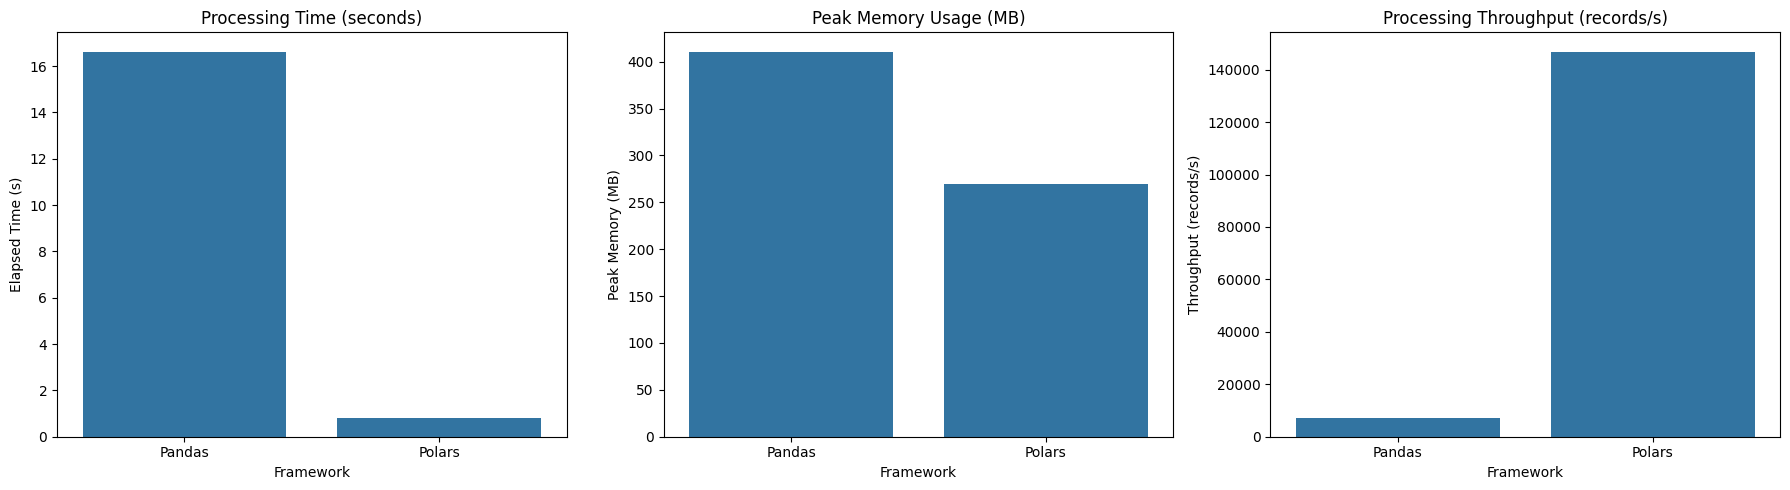

In [ ]:
# Build DataFrame for visualization
perf_df = pd.DataFrame({
    "Framework": ["Pandas", "Polars"],
    "Elapsed Time (s)": [elapsed_pandas, elapsed],
    "Peak Memory (MB)": [peak_mem_pandas, peak],
    "Records Processed": [df_copy.shape[0], df.shape[0]]
})

# Calculate throughput (records per second)
perf_df["Throughput (records/s)"] = perf_df["Records Processed"] / perf_df["Elapsed Time (s)"]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot: Processing Time
sns.barplot(data=perf_df, x="Framework", y="Elapsed Time (s)", ax=axes[0])
axes[0].set_title("Processing Time (seconds)")

# Plot: Peak Memory Usage
sns.barplot(data=perf_df, x="Framework", y="Peak Memory (MB)", ax=axes[1])
axes[1].set_title("Peak Memory Usage (MB)")

# Plot: Processing Throughput
sns.barplot(data=perf_df, x="Framework", y="Throughput (records/s)", ax=axes[2])
axes[2].set_title("Processing Throughput (records/s)")

# Tight layout for better formatting
plt.tight_layout()
plt.show()

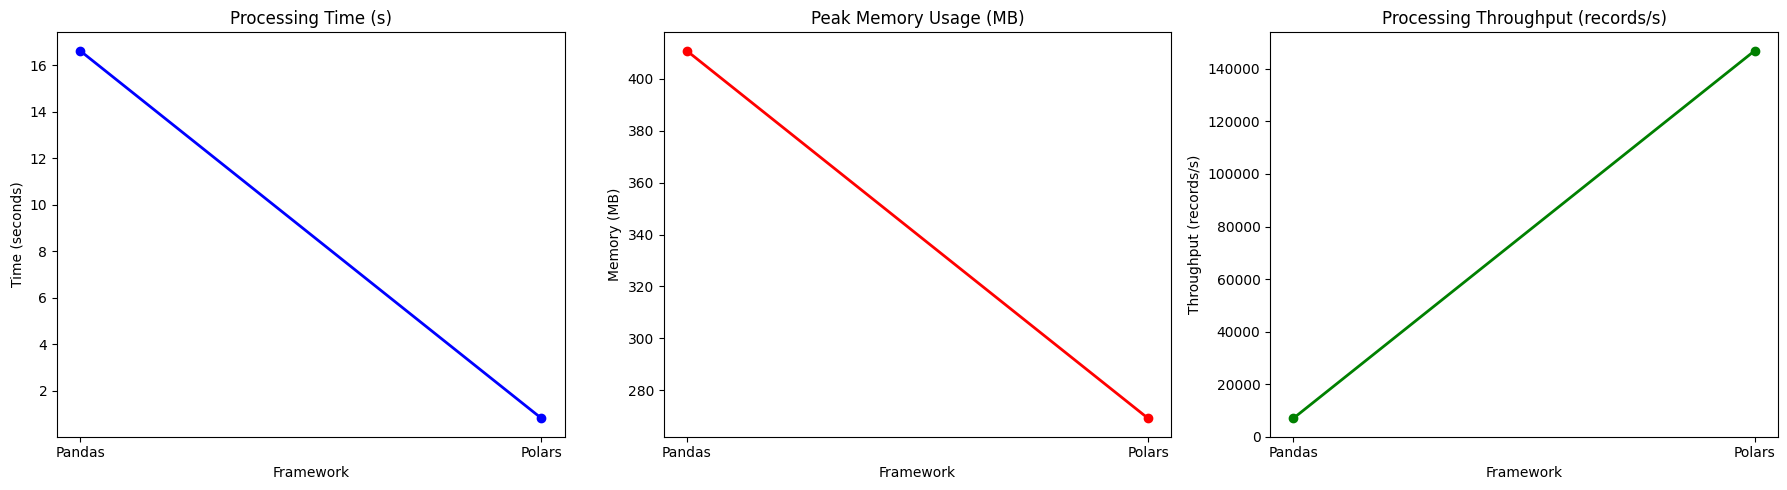

In [ ]:
# Prepare the data for plotting the line graph
frameworks = ["Pandas", "Polars"]
elapsed_time = [elapsed_pandas, elapsed]
peak_memory = [peak_mem_pandas, peak]
throughput = [df_copy.shape[0] / elapsed_pandas, df.shape[0] / elapsed]

# Create the figure and axis objects for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot: Processing Time (Line Graph)
axes[0].plot(frameworks, elapsed_time, marker='o', color='b', linestyle='-', linewidth=2)
axes[0].set_title("Processing Time (s)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Time (seconds)")

# Plot: Peak Memory Usage (Line Graph)
axes[1].plot(frameworks, peak_memory, marker='o', color='r', linestyle='-', linewidth=2)
axes[1].set_title("Peak Memory Usage (MB)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Memory (MB)")

# Plot: Processing Throughput (Line Graph)
axes[2].plot(frameworks, throughput, marker='o', color='g', linestyle='-', linewidth=2)
axes[2].set_title("Processing Throughput (records/s)")
axes[2].set_xlabel("Framework")
axes[2].set_ylabel("Throughput (records/s)")

# Add tight layout for better formatting
plt.tight_layout()
plt.show()
